In [1]:
import os
import sys
import data

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from collections import OrderedDict
from options.test_options import TestOptions
from models.pix2pix_model import Pix2PixModel

# Initialize model

In [2]:
sys.argv = [sys.argv[0]]
sys.argv += '--name pretrained_vg_attributes_onestep --dataset_mode vg_sparse --embed_attributes --batchSize 1'.split(' ')
opt = TestOptions().parse()

----------------- Options ---------------
             aspect_ratio: 1.0                           
          attention_heads: 6                             
             attr_emb_dim: 64                            
                  attr_nc: 256                           
                batchSize: 1                             
     bert_embedding_level: -2                            
      cache_filelist_read: False                         
     cache_filelist_write: False                         
          checkpoints_dir: ./checkpoints                 
      concat_all_captions: False                         
                crop_size: 256                           
                 dataroot: ./datasets/cityscapes/        
             dataset_mode: vg_sparse                     	[default: coco_sparse]
          display_winsize: 256                           
         embed_attributes: True                          	[default: False]
           embed_captions: False                

In [3]:
model = Pix2PixModel(opt)
for param in model.parameters():
    param.requires_grad = False
model.eval()
if torch.cuda.is_available():
    model = model.cuda()

Network [SPADEGenerator] was created. Total number of parameters: 96.5 million. To see the architecture, do print(network).


# Interactive editing

<IPython.core.display.Javascript object>


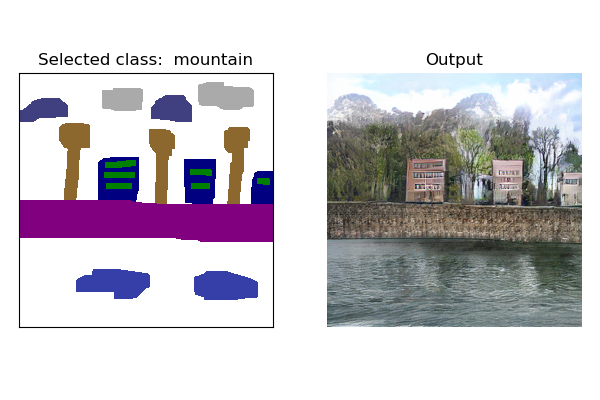

interactive(children=(Select(description='Class (bg)', options=('000) [eraser]', '001) window', '002) tree', '…

Button(description='Save checkpoint', style=ButtonStyle())

Button(description='Restore checkpoint', style=ButtonStyle())

Button(description='Save as image', style=ButtonStyle())

Button(description='Reset', style=ButtonStyle())

In [4]:
%matplotlib notebook

import matplotlib
from matplotlib.widgets import TextBox, Button
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import imageio

from data.label_list import stuff_classes, thing_classes, vg_labels
from util.util import labelcolormap

label_names = vg_labels.copy()
label_names[0] = '[eraser]'
all_classes = [0] + stuff_classes + thing_classes

cmap_arr = labelcolormap(opt.label_nc)
cmap = matplotlib.colors.ListedColormap(cmap_arr/255)
semantic_buffer = torch.FloatTensor(1, opt.label_nc, 256, 256).zero_()
attribute_buffer = torch.FloatTensor(1, opt.attr_nc, 256, 256).zero_()
if torch.cuda.is_available():
    semantic_buffer = semantic_buffer.cuda()
    attribute_buffer = attribute_buffer.cuda()
sem_buffer = torch.LongTensor(256, 256).zero_().pin_memory()
im_buffer = np.zeros((256, 256, 3), dtype=np.float32)

history = []

def redraw():
    with torch.no_grad():
        semantic_buffer.zero_()
        semantic_map = sem_buffer.unsqueeze(0).unsqueeze(0).to(semantic_buffer.device, non_blocking=True)
        semantic_buffer.scatter_(1, semantic_map, 1.0)
        generated = model.netG(semantic_buffer, attribute_buffer, None, None, None, None)
        im_buffer[:] = (generated.cpu().squeeze(0).permute(1, 2, 0).numpy() + 1) / 2
        output_im.set_data(im_buffer)

im_size = 6
fig = plt.figure(2, figsize=(im_size, im_size/2+1))
plt.subplots_adjust(wspace=0, hspace=0.03)

plt.subplot(1, 2, 1)
plt.title('Mask')
mask_im = plt.imshow(sem_buffer, cmap=cmap, vmin=0, vmax=280)
plt.xticks([])
plt.yticks([])
ax = plt.gca()

plt.subplot(1, 2, 2)
plt.title('Output')
output_im = plt.imshow(im_buffer)
plt.axis('off')

fig.tight_layout()
plt.show()

current_class = 1
prev_coords = None
def on_move(event):
    global history, prev_coords
    if event.inaxes and event.inaxes == ax and event.button in [1, 3]:
        x = int(event.xdata)
        y = int(event.ydata)
        # Left button: large radius
        # Right button: small radius
        rad = 6 if event.button == 1 else 3
        dp = (current_class, x, y, rad)
        if len(history) == 0 or dp != history[-1]:
            history.append(dp)
        
        sem_buffer[y-rad:y+rad, x-rad:x+rad] = current_class
        if prev_coords is not None:
            c = np.linspace(prev_coords, (x, y), abs(x - prev_coords[0]), endpoint=False, dtype=int)
            for x_, y_ in c:
                sem_buffer[y_-rad:y_+rad, x_-rad:x_+rad] = current_class
            
        mask_im.set_data(sem_buffer)
        prev_coords = (x, y)
    else:
        prev_coords = None
        
        
def on_release(event):
    redraw()
    
def update_class(cl):
    global current_class
    cl_id, cl_name = cl.split(')')
    current_class = int(cl_id)
    ax.set_title(f'Selected class: {cl_name}')

def save_checkpoint(_):
    global history_checkpoint
    history_checkpoint = (history.copy(), sem_buffer.clone())
    
def restore_checkpoint(_):
    global history, sem_buffer
    history = history_checkpoint[0].copy()
    sem_buffer[:] = history_checkpoint[1]
    mask_im.set_data(sem_buffer)
    redraw()
    
def save_to_file(_):
    imageio.imwrite('saved_drawing_label.png', cmap_arr[sem_buffer])
    imageio.imwrite('saved_drawing_image.png', (im_buffer*255).astype(np.uint8))
    ax.set_title(f'(!) Saved as saved_drawing_*.png')
    
def reset(_):
    sem_buffer.zero_()
    mask_im.set_data(sem_buffer)
    redraw()
    
history_checkpoint = (history.copy(), sem_buffer.clone())
        
fig.canvas.mpl_connect('motion_notify_event', on_move)
fig.canvas.mpl_connect('button_release_event', on_release)

class_box = widgets.Select(options=[f'{x:03d}) ' + label_names[y] for x, y in enumerate(all_classes)],
                              description='Class (bg)')

checkpoint_button = widgets.Button(description='Save checkpoint')
checkpoint_button.on_click(save_checkpoint)
restore_button = widgets.Button(description='Restore checkpoint')
restore_button.on_click(restore_checkpoint)
save_button = widgets.Button(description='Save as image')
save_button.on_click(save_to_file)
reset_button = widgets.Button(description='Reset')
reset_button.on_click(reset)

interact(update_class, cl=class_box)
display(checkpoint_button)
display(restore_button)
display(save_button)
display(reset_button)